In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from numpy import floor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings("ignore")

format = 2
grounds = ['Kennington Oval', 'Trent Bridge', 'County Ground Bristol', 'The Rose Bowl', 'The Cooper Associates County Ground', 'Emirates Old Trafford', 'Edgbaston', 'Headingley', "Lord's", 'Riverside Ground', 'Sophia Gardens']
# india = ['Chinnaswamy Stadium', 'MA Chidambaram Stadium', 'Narendra Modi Stadium', 'Arun Jaitley Cricket Stadium', 'Himachal Pradesh Cricket Association Stadium', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium', 'Rajiv Gandhi International Cricket Stadium', 'Maharashtra Cricket Association Stadium', 'Eden Gardens', 'Wankhede Stadium']
        # tr['Ground'] = tr['Ground'].replace('The Oval', 'Kennington Oval', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Birmingham', 'Edgbaston', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Leeds', 'Headingley', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Southampton', 'The Rose Bowl', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Manchester', 'Emirates Old Trafford', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Cardiff', 'Sophia Gardens', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Bristol', 'County Ground Bristol', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Nottingham', 'Trent Bridge', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Chester-le-Street', 'Riverside Ground', regex=True)
        # tr['Ground'] = tr['Ground'].replace('Taunton', 'The Cooper Associates County Ground', regex=True)

        # lr['Ground'] = lr['Ground'].replace('Ahmedabad', 'Narendra Modi Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Bengaluru', 'Chinnaswamy Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Chennai', 'MA Chidambaram Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Delhi', 'Arun Jaitley Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Dharamsala', 'Himachal Pradesh Cricket Association Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Lucknow', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Hyderabad', 'Rajiv Gandhi International Cricket Stadium', regex=True)
        # lr['Ground'] = lr['Ground'].replace('Pune', 'Maharashtra Cricket Association Stadium', regex=True)

In [ ]:
g = pd.DataFrame()

for ground in grounds:
    url = "http://search.espncricinfo.com/ci/content/ground/search.html?search=" + ground.lower().replace(" ","+") + "&x=0&y=0"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")

    if ground == "Lord's":
        df = pd.read_html(f'https://stats.espncricinfo.com/ci/engine/ground/57129.html?class=2;template=results;type=aggregate;view=innings')[3]
    else:
        ground_id = str(soup.find_all(class_='ColumnistSmry')[-1]).split('.html')[0].split('/')[-1]
        df = pd.read_html(f'https://stats.espncricinfo.com/ci/engine/ground/{ground_id}.html?class={format};template=results;type=aggregate;view=innings')[3]

    df[['Score', 'Wkts']] = df['Score'].str.split('/', expand=True)
    df['Wkts'] = df['Wkts'].fillna(0)
    df = df.rename(columns={'Unnamed: 10': 'Match No'})
    df = df.drop(columns=['Unnamed: 7'])
    df['Score'] = pd.to_numeric(df['Score'], errors='coerce')
    df['Wkts'] = pd.to_numeric(df['Wkts'], errors='coerce')
    df['Score'] = df['Score'].fillna(0)
    df['Start Date'] = pd.to_datetime(df['Start Date'])
    df = df[df['Start Date'].dt.year >= 2000]
    df = df[df['Result'] != 'n/r']
    df = df[['Team', 'Score', 'Wkts', 'Overs', 'Target', 'RPO', 'Inns', 'Result', 'Opposition', 'Start Date', 'Match No']]
    df1st = df.iloc[::2].reset_index(drop=True)
    df2nd = df.iloc[1::2].reset_index(drop=True)
    df1st = df1st.drop(columns=['Target'])

    sc1_avg = df1st['Score'].mean().round(2)
    sc1_sd = df1st['Score'].std().round(2)
    wkt1_avg = df1st['Wkts'].mean().round(2)
    wkt1_sd = df1st['Wkts'].std().round(2)
    countw = df1st['Result'].value_counts().get('won', 0)
    countl = df1st['Result'].value_counts().get('lost', 0)

    sc2_avg = df2nd['Score'].mean().round(2)
    sc2_sd = df2nd['Score'].std().round(2)
    wkt2_avg = df2nd['Wkts'].mean().round(2)
    wkt2_sd = df2nd['Wkts'].std().round(2)

    row = pd.DataFrame({'Name': [ground], 'Won batting first': [countw], 'Won batting second': [countl],
                        'Avg 1st Inngs Score': [sc1_avg], 'Std Dev - 1st Inngs Score': [sc1_sd],
                        'Avg 1st Inngs Wkts': [wkt1_avg], 'Std Dev - 1st Inngs Wkts': [wkt1_sd],
                        'Avg 2nd Inngs Score': [sc2_avg], 'Std Dev - 2nd Inngs Score': [sc2_sd],
                        'Avg 2nd Inngs Wkts': [wkt2_avg], 'Std Dev - 2nd Inngs Wkts': [wkt2_sd]})

    g = pd.concat([g, row], ignore_index=True)
g = g.reset_index(drop=True)
g.index = g.index + 1


In [ ]:
g['Straight1'] = [68, 72, 63, 82, 65, 70, 66, 70, 82, 72, 60]
g['Straight2'] = [66, 64, 66, 82, 68, 73, 73, 65, 70, 72, 64]
g['Side1'] = [67, 64, 67, 76, 65, 65, 63, 72, 65, 78, 74]
g['Side2'] = [70, 64, 69, 76, 64, 77, 69, 66, 60, 74, 72]
# g['Spin'] = [0,0,0,0,0,0,0,0,0,0,0]
# g['Swing'] = [0,0,0,0,0,0,0,0,0,0,0]
# g['Bounce'] = [0,0,0,0,0,0,0,0,0,0,0]
g
g.to_csv("/content/Pitch_Data/original.csv", index=False)

In [ ]:
# # Save the original data types to a JSON file
# data_types_file = '/content/Data/pitch.json'
# data_types = g.dtypes.to_dict()
# with open(data_types_file, 'w') as f:
#     json.dump(data_types, f)

# # Convert the DataFrame to CSV without preserving data types (default behavior)
# csv_file = '/content/Data/pitch.csv'
# df.to_csv(csv_file, index=False)

In [ ]:
# Given data
data = {
    'Name': g['Name'].tolist(),
    'Won batting first': g['Won batting first'].tolist(),
    'Won batting second': g['Won batting second'].tolist(),
    'Avg 1st Inngs Score': g['Avg 1st Inngs Score'].tolist(),
    'Std Dev - 1st Inngs Score': g['Std Dev - 1st Inngs Score'].tolist(),
    'Avg 1st Inngs Wkts': g['Avg 1st Inngs Wkts'].tolist(),
    'Std Dev - 1st Inngs Wkts': g['Std Dev - 1st Inngs Wkts'].tolist(),
    'Avg 2nd Inngs Score': g['Avg 2nd Inngs Score'].tolist(),
    'Std Dev - 2nd Inngs Score': g['Std Dev - 2nd Inngs Score'].tolist(),
    'Avg 2nd Inngs Wkts': g['Avg 2nd Inngs Wkts'].tolist(),
    'Std Dev - 2nd Inngs Wkts': g['Std Dev - 2nd Inngs Wkts'].tolist(),
}

In [ ]:
# Convert data to a DataFrame
df = pd.DataFrame(data)

# Calculate Z-scores and normalize the features
df['Z_Score_Avg_1st_Wkts'] = (df['Avg 1st Inngs Wkts'] - df['Avg 1st Inngs Wkts'].mean()) / df['Std Dev - 1st Inngs Wkts']
df['Spin_Pace_Friendly'] = (df['Z_Score_Avg_1st_Wkts'] + 3) / 6
df['Z_Score_Avg_1st_Score'] = (df['Avg 1st Inngs Score'] - df['Avg 1st Inngs Score'].mean()) / df['Std Dev - 1st Inngs Score']
df['Batting_Bowling_Friendly'] = (df['Z_Score_Avg_1st_Score'] + 3) / 6

# Encode the pitch names to numerical values
label_encoder = LabelEncoder()
df['Pitch_ID'] = label_encoder.fit_transform(df['Name'])

# Features (X) and target (y) variables
X = df[['Spin_Pace_Friendly', 'Batting_Bowling_Friendly', 'Pitch_ID']]
y = df['Won batting first'] > df['Won batting second']  # True if won batting first, False if won batting second


# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [ ]:
# Pitch name as input
pitch_name = 'Kennington Oval'  # Change this to the desired pitch name

# Encode the input pitch name to numerical value
input_pitch_id = label_encoder.transform([pitch_name])[0]

In [ ]:
# Create input features for the prediction
input_features = [[df.loc[df['Name'] == pitch_name, 'Spin_Pace_Friendly'].values[0],
                   df.loc[df['Name'] == pitch_name, 'Batting_Bowling_Friendly'].values[0],
                   input_pitch_id]]

# Predict the probabilities for spin/pace and batting/bowling for the input pitch
spin_pace_probability = model.predict_proba(input_features)[:, 1][0]
batting_bowling_probability = model.predict_proba(input_features)[:, 0][0]

In [ ]:
# # ... (your existing code to calculate probabilities goes here) ...

# # Store the probabilities using %store magic command
# %store spin_pace_probability
# %store batting_bowling_probability

In [ ]:
print(f"Probability of {pitch_name} being spin-friendly/pace-friendly: {spin_pace_probability:.2f}")
print(f"Probability of {pitch_name} being batting-friendly/bowling-friendly: {batting_bowling_probability:.2f}")

Probability of Kennington Oval being spin-friendly/pace-friendly: 0.19
Probability of Kennington Oval being batting-friendly/bowling-friendly: 0.81


In [ ]:
# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Pitch Name', 'Spin/Pace Probability', 'Batting/Bowling Probability'])

# Loop through all pitch names and calculate probabilities
for pitch_name in df['Name']:
    # Encode the input pitch name to numerical value
    input_pitch_id = label_encoder.transform([pitch_name])[0]

    # Create input features for the prediction
    input_features = [[df.loc[df['Name'] == pitch_name, 'Spin_Pace_Friendly'].values[0],
                       df.loc[df['Name'] == pitch_name, 'Batting_Bowling_Friendly'].values[0],
                       input_pitch_id]]

    # Predict the probabilities for spin/pace and batting/bowling for the input pitch
    spin_pace_probability = model.predict_proba(input_features)[:, 1][0]
    batting_bowling_probability = model.predict_proba(input_features)[:, 0][0]

    # Add the results to the DataFrame
    result_df = result_df.append({'Pitch Name': pitch_name,'Spin/Pace Probability': spin_pace_probability,'Batting/Bowling Probability': batting_bowling_probability},ignore_index=True)

# Display the result DataFrame
print(result_df)

                             Pitch Name  Spin/Pace Probability  \
0                       Kennington Oval               0.193750   
1                          Trent Bridge               0.074738   
2                 County Ground Bristol               0.332347   
3                         The Rose Bowl               0.088383   
4   The Cooper Associates County Ground               0.104095   
5                 Emirates Old Trafford               0.257203   
6                             Edgbaston               0.293145   
7                            Headingley               0.223341   
8                                Lord's               0.167183   
9                      Riverside Ground               0.143275   
10                       Sophia Gardens               0.122562   

    Batting/Bowling Probability  
0                      0.806250  
1                      0.925262  
2                      0.667653  
3                      0.911617  
4                      0.895905  
5  

In [ ]:
# Define the classification criteria
def classify_pitch(spin_pace_prob, batting_bowling_prob):
    if spin_pace_prob <= 0.25:
        spin_pace_category = 'Good Fast Pitch'
    elif spin_pace_prob <= 0.5:
        spin_pace_category = 'Moderate Fast Pitch'
    elif spin_pace_prob <= 0.75:
        spin_pace_category = 'Moderate Spin Pitch'
    else:
        spin_pace_category = 'Good Spin Pitch'

    if batting_bowling_prob < 0.5:
        batting_bowling_category = 'Good Bowling Pitch'
    else:
        batting_bowling_category = 'Good Batting Pitch'

    return spin_pace_category, batting_bowling_category

# Classify the pitches based on the defined criteria
result_df['Spin/Pace Category'], result_df['Batting/Bowling Category'] = zip(*result_df.apply(
    lambda row: classify_pitch(row['Spin/Pace Probability'], row['Batting/Bowling Probability']), axis=1))

# Group similar pitches into lists
grouped_pitches = result_df.groupby(['Spin/Pace Category', 'Batting/Bowling Category'])['Pitch Name'].apply(list)

# Convert the grouped data to a list of lists
similar_pitches_list = grouped_pitches.tolist()

# Display the list of lists
print(similar_pitches_list)
print(result_df)
result=result_df
result.to_csv("/content/Pitch_Data/pitch_report.csv", index=False)

[['Kennington Oval', 'Trent Bridge', 'The Rose Bowl', 'The Cooper Associates County Ground', 'Headingley', "Lord's", 'Riverside Ground', 'Sophia Gardens'], ['County Ground Bristol', 'Emirates Old Trafford', 'Edgbaston']]
                             Pitch Name  Spin/Pace Probability  \
0                       Kennington Oval               0.193750   
1                          Trent Bridge               0.074738   
2                 County Ground Bristol               0.332347   
3                         The Rose Bowl               0.088383   
4   The Cooper Associates County Ground               0.104095   
5                 Emirates Old Trafford               0.257203   
6                             Edgbaston               0.293145   
7                            Headingley               0.223341   
8                                Lord's               0.167183   
9                      Riverside Ground               0.143275   
10                       Sophia Gardens              

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6666666666666666


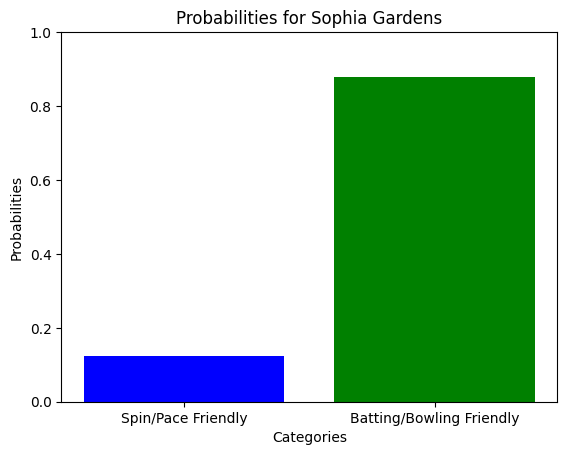

In [ ]:
labels = ['Spin/Pace Friendly', 'Batting/Bowling Friendly']
probabilities = [spin_pace_probability, batting_bowling_probability]

plt.bar(labels, probabilities, color=['blue', 'green'])
plt.xlabel('Categories')
plt.ylabel('Probabilities')
plt.title(f'Probabilities for {pitch_name}')
plt.ylim(0, 1)
plt.show()

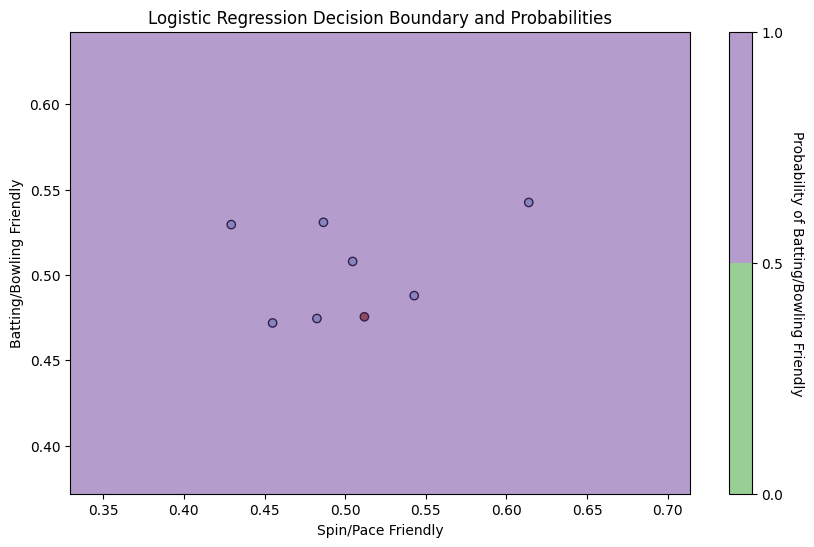

In [ ]:
# Plotting the graph with decision boundary
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(X_train['Spin_Pace_Friendly'], X_train['Batting_Bowling_Friendly'], c=y_train, cmap=plt.cm.Paired, edgecolors='k')

# Plot the decision boundary
x_min, x_max = X_train['Spin_Pace_Friendly'].min() - 0.1, X_train['Spin_Pace_Friendly'].max() + 0.1
y_min, y_max = X_train['Batting_Bowling_Friendly'].min() - 0.1, X_train['Batting_Bowling_Friendly'].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel(), np.zeros(xx.ravel().shape)])[:, 0]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap=plt.cm.Paired, alpha=0.5)

# Add color bar
cbar = plt.colorbar()
cbar.set_label('Probability of Batting/Bowling Friendly', rotation=270, labelpad=15)

# Label the axes
plt.xlabel('Spin/Pace Friendly')
plt.ylabel('Batting/Bowling Friendly')
plt.title('Logistic Regression Decision Boundary and Probabilities')

plt.show()